# **Introduction & Problem Statement**

In today’s banking and fintech landscape, effective management of credit risk is critical for business sustainability and regulatory compliance. Financial institutions seek to minimize loan defaults while maximizing opportunities to serve creditworthy customers.

Traditionally, credit approval decisions were made through rigid rules or manual assessments, both of which are prone to human bias and inefficient at scale. The growing volume of applicants and complexity of financial histories now demand robust, data-driven solutions.

**Business Objective:**  
To build a predictive machine learning model that can accurately classify loan applicants as "likely to default" or "not likely to default" based on their application and credit history data.

**Core Problem Statement:**  
Given historical application and credit data, can we automatically predict which new applicants are likely to default?  
The aim is to provide a tool that supports loan officers in approving/rejecting applications, thereby reducing defaults and improving overall portfolio health.

This project involves:
- Ingesting and preparing large-scale applicant and credit datasets
- Exploratory analysis to understand drivers of risk
- Building, evaluating, and interpreting a model for robust, real-world deployment
- Delivering actionable insights and a replicable framework for credit risk assessment


### 2. Import Libraries


In [2]:
# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

# Basic data handling libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt

# Survival analysis libraries (install and import)
!pip install lifelines -q
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test

# Pandas display options for better data viewing
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# Data loading (keep file paths and filenames as is)
credit = pd.read_csv(r"C:\Users\HP\Documents\credit_card\data\raw\credit_record.csv")
application = pd.read_csv(r"C:\Users\HP\Documents\credit_card\data\raw\application_record.csv")


In [4]:
application


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [5]:
credit 

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [6]:
len(set(application['ID'])) # how many unique ID in application record?


438510

In [7]:
len(set(credit['ID'])) # how many unique ID in credit record?

45985

In [8]:
len(set(application['ID']).intersection(set(credit['ID']))) # how many IDs do two tables share?


36457

### Vintage Analysis

In [9]:
grouped = credit.groupby('ID')
### convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe window
pivot_tb.reset_index(drop = True, inplace = True)
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left') # join calculated information
credit0 = credit.copy()
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

##### denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']

##### ventage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum'] 
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table
vintage

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [11]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers
vintage

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


Using pivot to convert long data to wide data:

In [12]:
### Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,0.024691,0.024691,0.026749,0.032922,0.034979,0.037037,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,0.019231,0.019231,0.023504,0.027778,0.027778,0.029915,0.029915,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,NaN,Na

This is a standard vingtage analysis table. The rows represent months of opening accounts, columns represent months after openning acounts, and values are accumlate past-due rate. As open-month closes to 0, the observe window shortens, thus the bottom half triangular field is filled by nan.

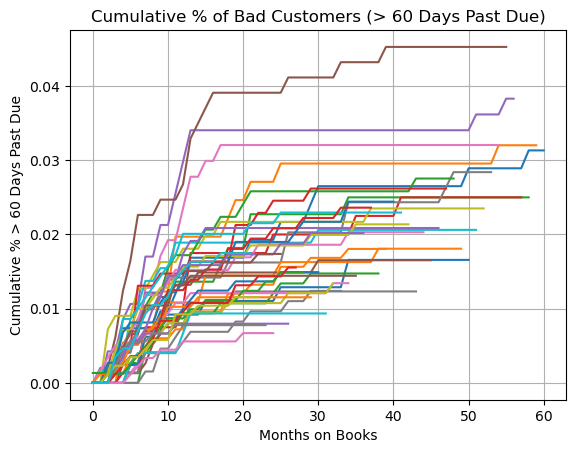

In [13]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()